In [1]:
# test script that puts it all together
import os
os.chdir('..')
print(os.getcwd())

D:\git\ai_workshop_2023


In [2]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt

### Optimal Behaviour and User Modelling

Optimal user behaviour reduces a target's energy most rapidly. This involves exactly tracking the target's position, instantly absorbing all potential energy as it is converted from kinetic energy. In practice real users have constraint precision and act with delays, both present in their visual perception, cognitive process, and motor execution. To capture delays and constraint precision, we model user input as a first-order lag with Gaussian noise.

#### First Order Lag User

A first order lag system receives a repeated step function control signal.

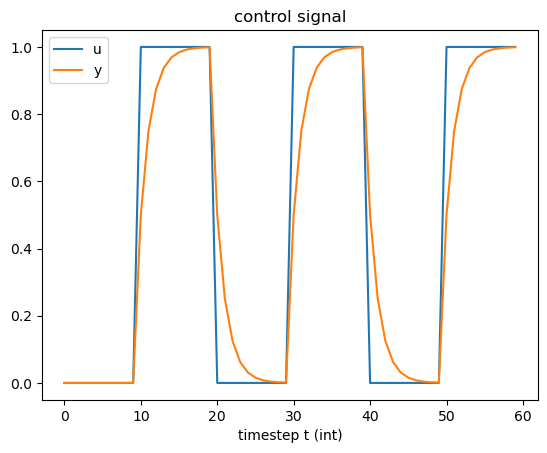

In [3]:

# control signal u
num_repetitions = 3
num_steps_per_phase = 10
u = np.hstack([np.zeros((num_repetitions, num_steps_per_phase)), np.ones((num_repetitions, num_steps_per_phase))]).reshape(-1)
plt.plot(u, label='u')
plt.title('control signal');
plt.xlabel('timestep t (int)');

# lag response
k = 0.5 # lag constant [0, 1]
y = np.zeros_like(u)
y[0] = 0
for t in range(1, u.shape[0]):
  y[t] = (1-k) * y[t-1] + k * u[t]
  
plt.plot(y, label='y')
plt.legend()

In [4]:
# 2. Wrap behavior in an agent class.
class FirstOrderLag:
  """"
  First order lag (vectorized).
  
  Args:
      conductivity (np.array): moving average weight of new input, in [0,1].
      s0 (np.array): initial state after reset. 
      bounds (np.array): minimum and maximum state values
  """
  
  def __init__(self, conductivity=0.5, s0=0, bounds=None):
    self.k = conductivity
    self.s0 = s0
    self.bounds = bounds
    
  def copy(self):
    other = FirstOrderLag(conductivity=self.k,
                          s0=self.s0,
                          bounds=self.bounds)
    other.s = self.s.copy()
    return other
    
  def reset(self):
    self.s = np.copy(self.s0)
    self.s = self._clip(self.s)
    return {'x': self.s, 'dx': np.zeros_like(self.s)}
  
  def step(self, u):
    s = (1-self.k) * self.s + self.k * u
    s = self._clip(s)
    ds = s - self.s
    self.s = s
    return {'x': self.s, 'dx': ds}
  
  def _clip(self, s):
    if self.bounds is None:
      return s
    
    return np.clip(s, self.bounds[0], self.bounds[1])

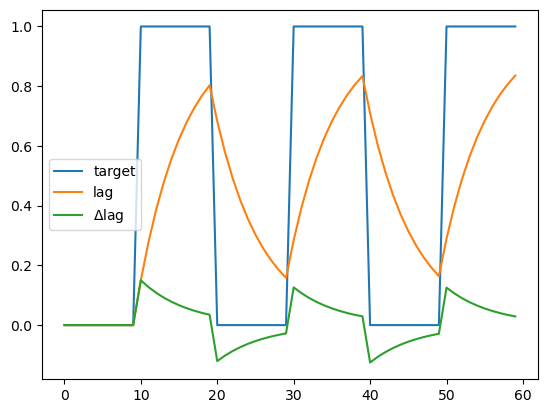

In [5]:
# 3. simulate agent response to control signal.
user = FirstOrderLag(conductivity=0.15)
y = [user.reset()] + [user.step(u[t]) for t in range(1, u.shape[0])]
plt.plot(u, label='target')
plt.plot([y['x'] for y in y], label='lag')
plt.plot([y['dx'] for y in y], label='$\Delta$lag')
plt.legend()

## User Interface

To illustrate how active inference can help adapt parameters of complex user interfaces to improve performance, we explore a target selection task with artificially complicated but well understood interaction dynamics. A visual display shows $N$ targets in motion mimicking the harmonic oscillation of masses on springs. All springs are *anchored* at the same height to a horizontal line that is controlled by the user. Each target has a different parametrization corresponding to different oscillation frequencies. A target is selected by reducing its mechanical energy to fall below some threshold $\tau$ while keeping all other targets' mechanical energies above the threshold. The mechanical energy is defined as the sum of potential energy and kinetic energy, with all energy being kinetic at the zero crossing and all energy being potential at the oscillation extrema. The oscillation amplitude thereby gives the user feedback about the effect of their inputs on progress towards selecting individual targets. Moving the anchor towards or away from a target reduces or increase its potential energy, respectively.

The harmonic oscillators act as a common mediating mechanism between various input spaces (e.g., trajectories of a mouse pointer, a visually tracked hand, gaze, or device tilting movements) and the control space (one of $N$ target selection). By decoupling the interaction metaphor from the specific input modality we can leverage users' mental model of the dynamics to make control across multiple modalities more intuitive, provided that parametrisations of the dynamics can be found that work well for each modality and user. Traditionally, finding good parametrisations was done manually or through trial and error user testing in each new context. More recently, computational interaction methods have been proposed, where user models trained via reinforcement learning are used to evaluate individual interface parametrisations in simulation  off-line. Here, we set out to demonstrate how active inference can be used to simultaneously learn the user model and adapt interface parametrisations to optimize task performance on-line, i.e. while a user interacts with the system.

### Harmonic Oscillators

We parametrise each harmonic oscillator with a mass $m$ and a spring constant $\kappa$, which correspond to the oscillation frequency in Eq. X
$$f=\frac{1}{2\pi}\sqrt{\frac{\kappa}{m}}$$

The state is represented by $(x, \dot x)$ , where $x$ is its distance from the anchor and $\dot x$ its velocity. The mechanical energy $E$, potential energy $U$, and kinetic energy $K$ are defined as in Eq. X
$$
E = U + K 
$$
$$ U = \frac{1}{2}\kappa \cdot x^2 $$
$$ K = \frac{1}{2}m \cdot \dot x^2 $$

The dynamics are described by an ordinary differential equation (ODE) and state updates are performed by taking one Euler step of length $\delta t$ (see Eq. X)

$$ \ddot x = \frac{F}{m} = \frac{-\kappa \cdot \dot x_t}{m} $$
$$ \dot x_t = \dot x_{t-1} + \delta t \cdot \ddot x_t $$
$$ x_t = x_{t-1} + \delta t \cdot \ \dot x_t$$



In [95]:
class HarmonicOscillator():
    
    def __init__(self, 
                 N=1, 
                 mass=1., 
                 spring_constant=1., 
                 damping_coefficient=0., 
                 dt=0.1, 
                 energy_start=1., 
                 energy_max=2):
      self.N = N
      self.mass_start = mass
      self.spring_start = spring_constant
      self.damping_start = damping_coefficient
      self.dt = dt # Euler step length
      self.energy_start = energy_start
      self.energy_max = energy_max
      
      self.x = None
      self.v = None
      self.anchor = 0
      
    def copy(self):
      other = HarmonicOscillator(N=self.N,
                                 mass=self.mass_start,
                                 spring_constant=self.spring_start,
                                 damping_coefficient=self.damping_start,
                                 dt=self.dt,
                                 energy_start=self.energy_start,
                                 energy_max=self.energy_max)
      other.mass = self.mass.copy()
      other.spring = self.spring.copy()
      other.damping = self.damping.copy()
      other.x = self.x.copy()
      other.v = self.v.copy()
      other.anchor = self.anchor
      return other               
      
    def frequency(self):
      return 1/(2*np.pi) * np.sqrt(self.spring / self.mass)
    
    def set_frequency(self, f, atol=1e-2):
      do_update = np.abs(f - self.frequency()) > atol
      e_before = self.energy()
      ratio = (2*np.pi*f)**2
      self.spring = do_update * ratio * self.mass_start + (1-do_update) * self.spring
      factor = e_before/self.energy()
      self.spring = self.spring * factor * do_update + (1-do_update) * self.spring
      self.mass = self.mass * factor * do_update + (1-do_update) * self.mass
      
    def set_energy(self, energy):
      u = self.potential_energy()
      k = self.kinetic_energy()
      e = self.energy()
      factor = energy/e
      dx = self.x - self.anchor
      self.x = np.sqrt(2 * u * factor / self.spring) * np.sign(dx) + self.anchor
      self.v = np.sqrt(2 * k * factor / self.mass) * np.sign(self.v)
    
    def potential_energy(self, x=None, spring=None):
      x = self.x if x is None else x
      dx = x - self.anchor
      spring = self.spring if spring is None else spring
      return 0.5 * spring * dx**2
    
    def kinetic_energy(self, v=None, mass=None):
      v = self.v if v is None else v
      mass = self.mass if mass is None else mass
      return 0.5 * mass * v**2
    
    def energy(self, x=None, v=None, spring=None, mass=None):
      return self.potential_energy(x, spring) + self.kinetic_energy(v, mass)
    
    def ddot_x(self, dx, v=None, spring=None, damping=None, mass=None):
      v = self.v if v is None else v
      spring = self.spring if spring is None else spring
      damping = self.damping if damping is None else damping
      mass = self.mass if mass is None else mass
      
      f_spring = -spring * dx # reduced spring should reduce spring force
      f_friction = -damping * v
      f_total = f_spring + f_friction
      a = f_total / mass # reduced mass should increase acceleration
      return a
    
    def reset(self):
      # self.anchor = self.anchor_start
      self.mass = self.mass_start * np.ones(self.N)
      self.spring = self.spring_start * np.ones(self.N)
      self.damping = self.damping_start * np.ones(self.N)
      
      # initialise all targets with equal energy and different phase
      phase = np.linspace(0, 2*np.pi, self.N+1)[:-1]
      e = self.energy_start # total mechanical energy
      max_x = np.sqrt(2*e/self.spring) # amplitude along x
      self.x = max_x * np.sin(phase) + self.anchor
      # note: maximum avoids numerical instability near zero in sqrt
      k = np.maximum(0, e - self.potential_energy())
      self.v = np.sqrt(2*k/self.mass) * np.sign(np.cos(phase))
      return {'x': self.x, 'v': self.v, 
              'debug': {'energy': self.energy(), 'mass': self.mass, 'spring': self.spring}
              }
    
    def step(self, action=0):
      # make hypothetical step with original parameters
      self.anchor = action
      dx = self.x - self.anchor
      a = self.ddot_x(dx)
      self.v = self.v + self.dt * a
      self.x = self.x + self.dt * self.v
      
      # boundary condition: limit energy
      e = self.energy()
      self.set_energy(np.minimum(e, self.energy_max))
      
      return {'x': self.x, 'v': self.v, 
              'debug': {'energy': self.energy(), 'mass': self.mass, 'spring': self.spring}
             }
    
    def plot_phase_space(self, axis=None):
      if axis is None:
        _, axis = plt.subplots()
      num_steps = int(np.max(1/(self.frequency() * self.dt))) + 2
      outputs = ['x', 'v']
      if self.x is None:
        self.reset()
      
      states = {o: [] for o in outputs}
      for _ in range(num_steps):
        state = self.step()
        for o in outputs:
          states[o].append(state[o])
      
      plt.sca(axis)
      plt.plot(np.array(states['x']), np.array(states['v']), '-')
      plt.title('Phase space');
      plt.xlabel('$x$')
      plt.ylabel("$\dot x$")
        

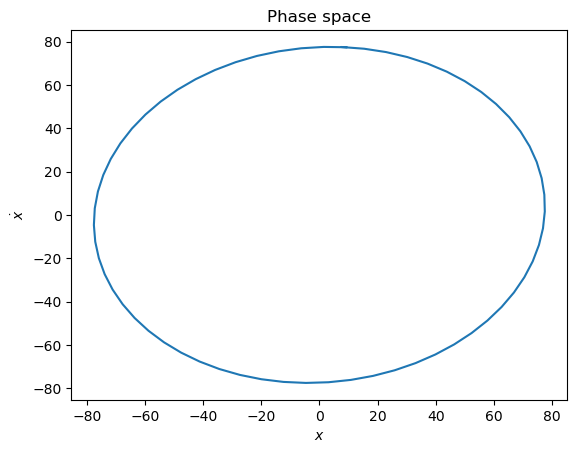

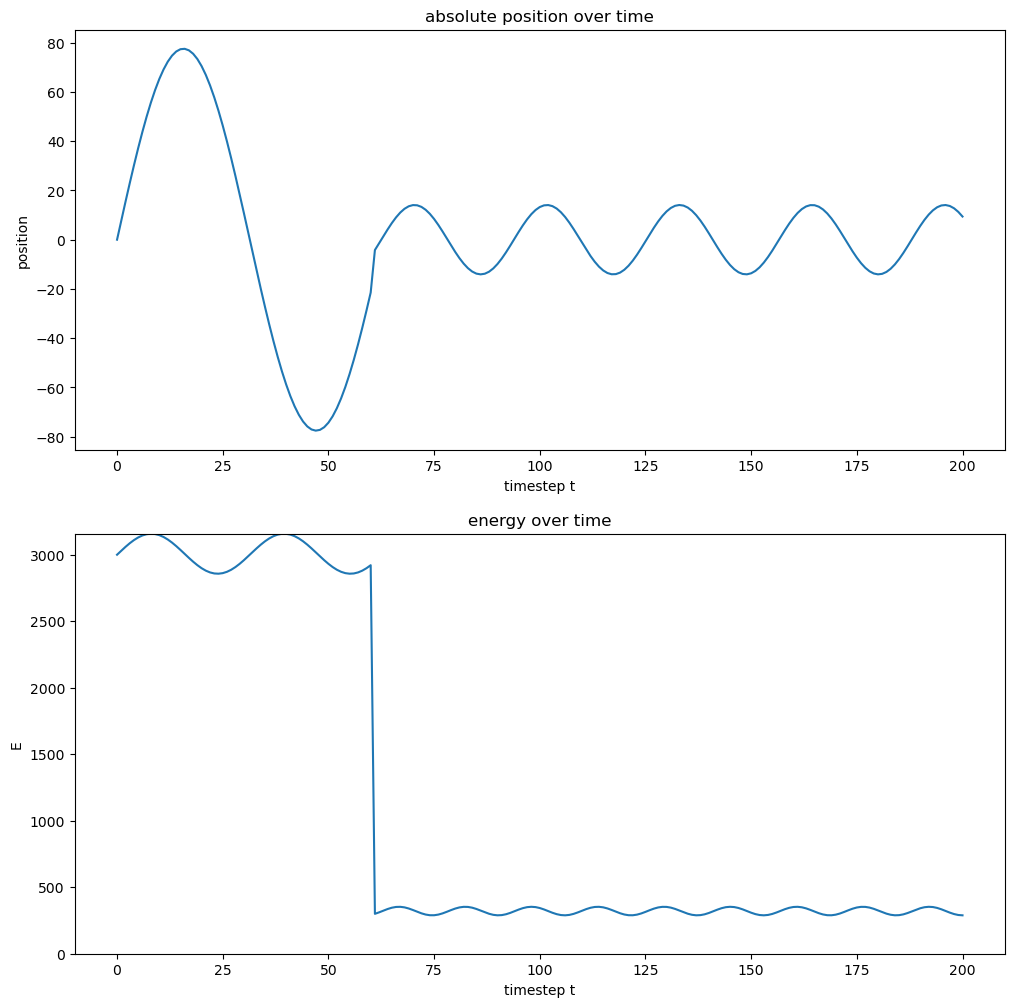

In [96]:
# 5. simulate uncontrolled MassSpringDamper
num_steps = 200
agent = HarmonicOscillator(N=1, dt=0.1, energy_start=3e3, energy_max=6e3)
agent.reset()
agent.plot_phase_space()

os = [agent.reset()]
for i in range(num_steps):
  if i == 60:
    # change frequency
    f = agent.frequency()
    e = agent.energy()
    # change energy
    agent.set_energy(e*0.1)
    agent.set_frequency(f*2.)
    #agent.set_energy(e*0.99)
    #agent.plot_phase_space(axis=plt.gca())
    #print(e, '->', agent.energy())
    
  os.append(agent.step())

fig, axes = plt.subplots(2, 1, figsize=(2*6, 12))

plt.sca(axes[0])
plt.title('absolute position over time')
xs = [o['x'] for o in os]
plt.plot(xs)
plt.ylabel('position')
plt.xlabel('timestep t')

plt.sca(axes[1])
plt.title('energy over time')
es = [o['debug']['energy'] for o in os]
plt.plot(es)
plt.ylabel('E')
plt.xlabel('timestep t')
plt.ylim([0, np.max(es)]);


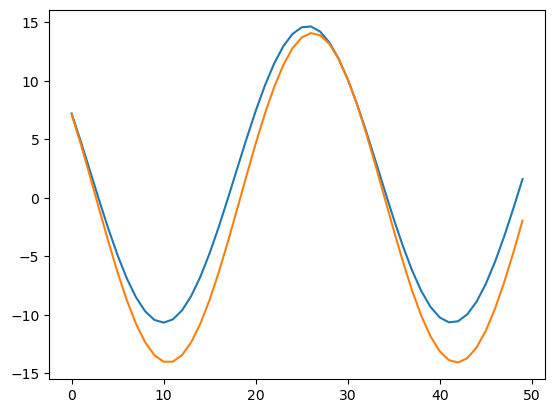

In [97]:
# debug copy constructor
ho = agent.copy()
ys_new = [ho.step(2)['x'] for _ in range(50)]
ys_old = [agent.step()['x'] for _ in range(50)]
plt.plot(ys_new)
plt.plot(ys_old)

Text(0, 0.5, 'x')

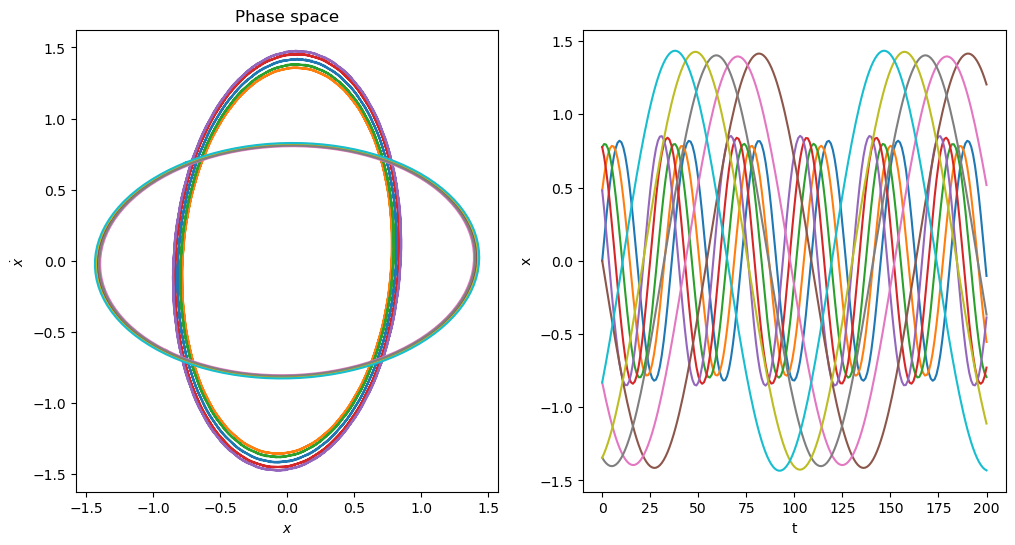

In [98]:
# simulate dynamics of oscillators with different parameters and different energy
num_objects = 5
mass = np.hstack([ 1 * np.ones((num_objects)), 3 * np.ones(num_objects)]).reshape(-1)
spring = np.hstack([ 3 * np.ones((num_objects)), 1 * np.ones(num_objects)]).reshape(-1)
agent = HarmonicOscillator(N=2*num_objects, mass=mass, spring_constant=spring)

fig, axes = plt.subplots(1, 2, figsize=(2*6, 6))
agent.reset()
agent.plot_phase_space(axes[0])

xs = [agent.reset()['x']]
for _ in range(num_steps):
  xs.append(agent.step()['x'])
  
plt.sca(axes[-1])
plt.plot(xs);
plt.xlabel('t')
plt.ylabel('x')

# User-UI Interaction

## Single object to control

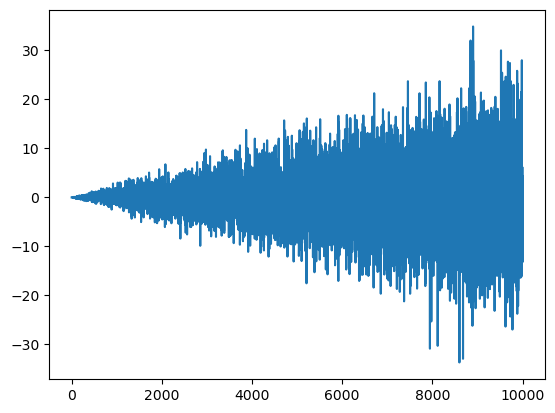

In [99]:
class Gaussian:
  """ Gaussian agent. Adds Gaussian noise to its input. """
  def __init__(self, rng, stdev=1., a0=0, mode='additive'):
    self.rng = rng
    self.stdev = stdev
    self.a0 = a0 # assumed starting input
    self.mode = mode # {'additive', 'scaled'}

    self.sample = self._sample_additive
    if self.mode == 'multiply':
      self.sample = self._sample_multiplicative
    
  def reset(self):
    return self.sample(self.a0)
  
  def step(self, a):
    return self.sample(a)
  
  def _sample_additive(self, a):
    return a + self.rng.normal(size=np.asarray(a).shape) * self.stdev
  
  def _sample_multiplicative(self, a):
    return a * self.rng.normal(size=np.asarray(a).shape) * self.stdev

  
gaussian = Gaussian(rng=rng, stdev=0.1, a0=0, mode='multiply')
xs = [gaussian.step(i*0.01) for i in range(10000)]
plt.plot(xs);

In [100]:
class NoisyLag:
  """ 
  First-order lag on noisy observations. 
  Used as a model for user input. 
  """
  
  def __init__(self, noise, lag):
    self.noise = noise
    self.lag = lag
    
  def reset(self):
    # treat lag value as noisy observation of the state
    x = self.lag.reset()['x']
    x_noisy = self.noise.step(x)
    self.lag.s = x_noisy
    return {'x': x_noisy, 'dx': 0}
    
  def step(self, action):
    # noisy percept of true position
    x_noisy = self.noise.step(action)
    # tracking perceived position
    return self.lag.step(x_noisy)
    
    

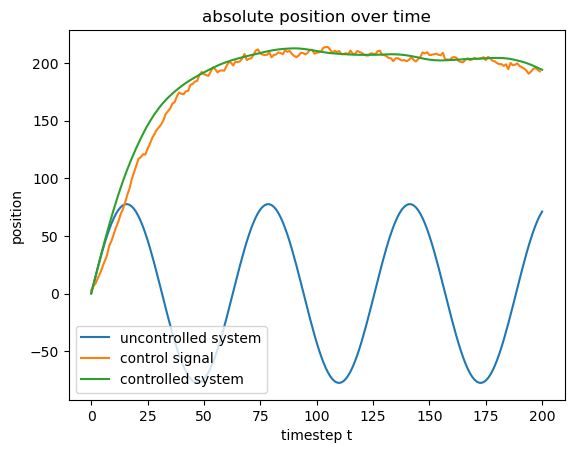

In [101]:
# 6. simulate MassSpringDamper controlled by FirstOrderLag
num_steps = 200

ui = HarmonicOscillator(energy_start=3e3, energy_max=6e3)
# generate an uncontrolled sequence
ui.reset()
xs = [ui.reset()['x']] + [ui.step()['x'] for _ in range(num_steps)]

# close the loop with a first-order lag user
user_lag = FirstOrderLag(conductivity=0.2)
user_noise = Gaussian(stdev=10., rng=rng)
user = NoisyLag(lag=user_lag, noise=user_noise)
user.reset()
os_user = []
os_ui = [ui.reset()]
for i in range(num_steps):
  # user response to UI stimulus
  o_user = user.step(os_ui[-1]['x'])
  os_user.append(o_user)
  
  # UI update in response to user
  os_ui.append(ui.step(o_user['x']))
  
plt.plot(xs, label='uncontrolled system')
plt.plot([o['x'] for o in os_user], label='control signal')
plt.plot([o['x'] for o in os_ui], label='controlled system')
plt.title('absolute position over time')
plt.xlabel('timestep t')
plt.ylabel('position')
plt.legend()

## Selective control

Text(0.5, 0, 'timestep t')

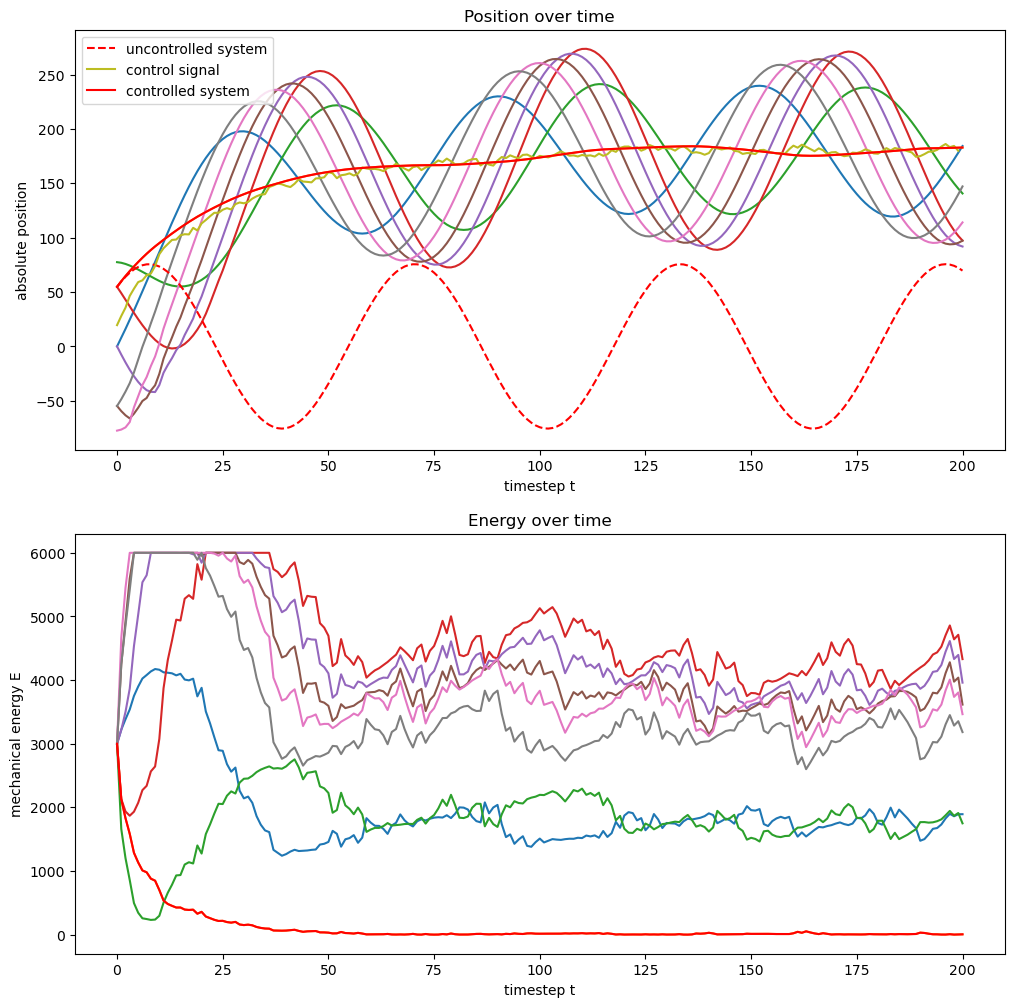

In [102]:
# 7. simulate a set of MassSpringDampers with different mass and selective control with FirstOrderLag
num_targets = 8
num_steps = 200
user_target = 1

ui = HarmonicOscillator(N=num_targets, energy_start=3e3, energy_max=6e3)
# generate an uncontrolled sequence
ui.reset()
xs_uncontrolled = [ui.reset()['x']] + [ui.step()['x'] for _ in range(num_steps)]

# close the loop with a first-order lag user
user_lag = FirstOrderLag(conductivity=0.2)
user_noise = Gaussian(stdev=10., rng=rng)
user = NoisyLag(lag=user_lag, noise=user_noise)
user.reset()
os_user = []
os_ui = [ui.reset()]
for i in range(num_steps):
  # user response to UI stimulus
  o_user = user.step(os_ui[-1]['x'][user_target])
  os_user.append(o_user)
  # UI update in response to user
  os_ui.append(ui.step(o_user['x']))
  
fig, ax = plt.subplots(2, 1, figsize=(2*6, 12))

plt.sca(ax[0])
plt.title('Position over time')
xs = [o['x'] for o in os_ui]
plt.plot(xs)
plt.plot(np.array(xs_uncontrolled)[:,user_target], 'r--', label='uncontrolled system')
plt.plot([o['x'] for o in os_user], label='control signal')
plt.plot(np.array(xs)[:,user_target], 'r', label='controlled system')
plt.xlabel('timestep t')
plt.ylabel('absolute position')
plt.legend()


plt.sca(ax[1])
plt.title('Energy over time')
es = [o['debug']['energy'] for o in os_ui]
plt.plot(es)
plt.plot(np.array(es)[:,user_target], 'r')
plt.ylabel('mechanical energy E')
plt.xlabel('timestep t')

## Selection Trigger (naive)

As the number of targets increases
- the threshold needs lowered
- the EMA conductivity needs to be reduced


Text(0.5, 1.0, 'smoothed energy over time')

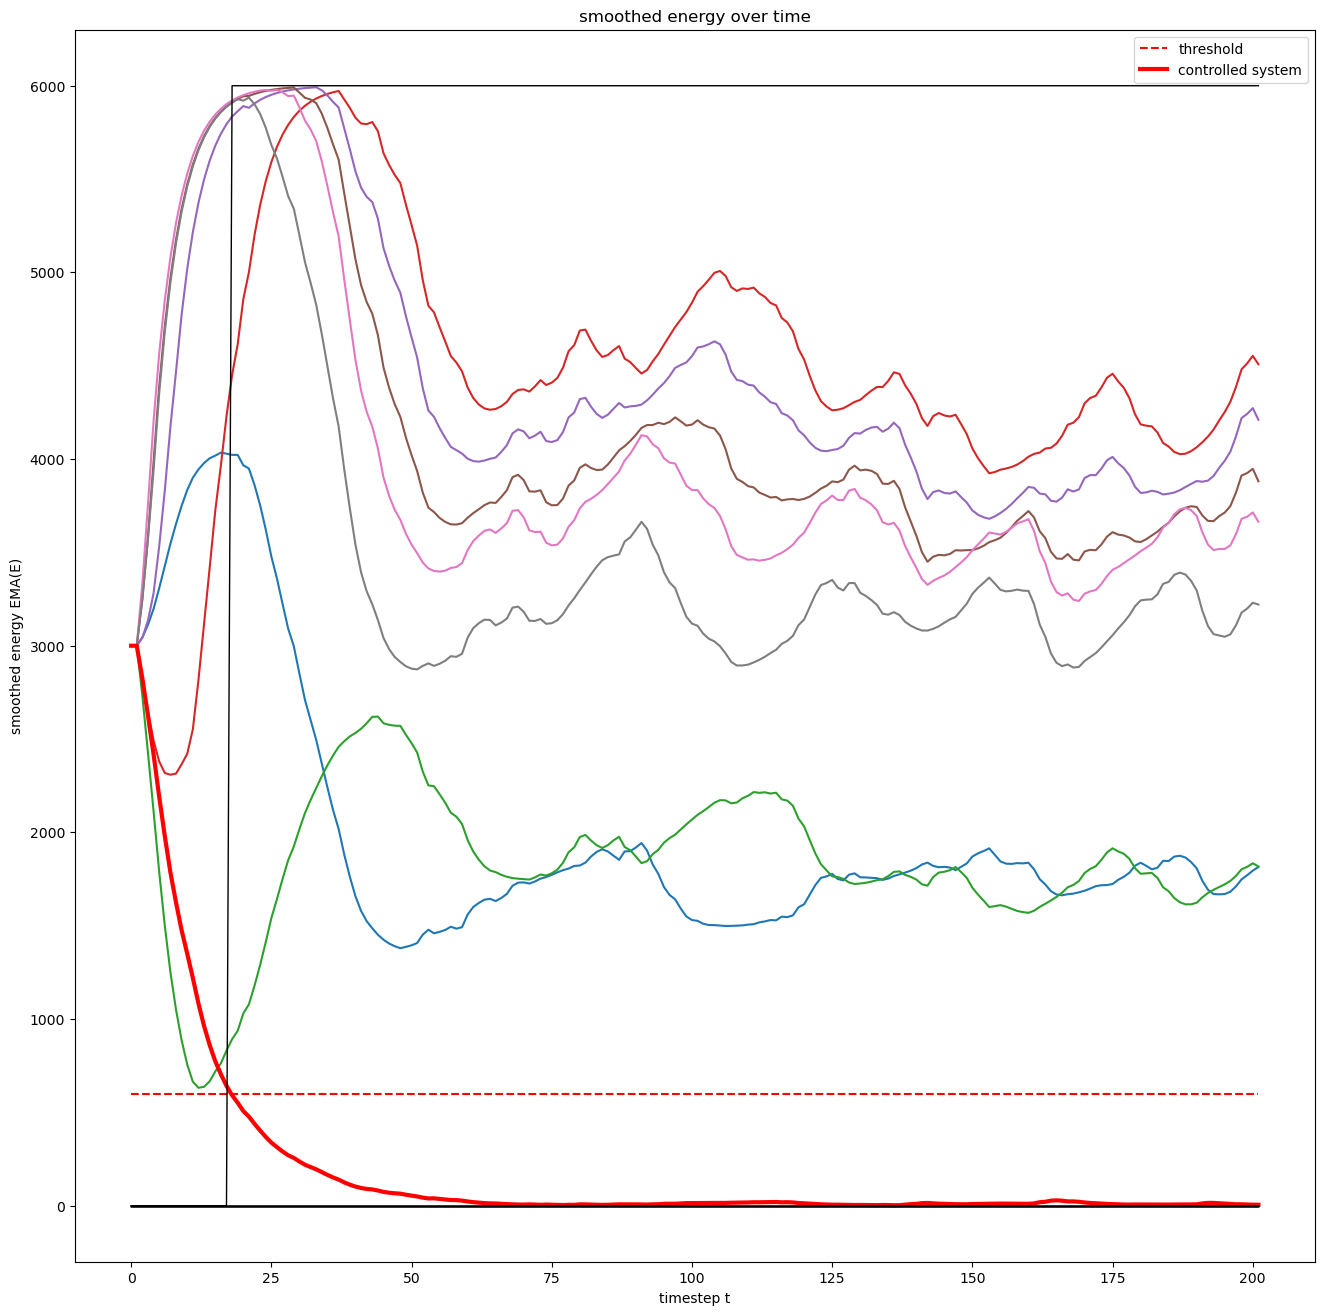

In [103]:
# exponential moving average (first-order lag)

energy_start = ui.energy_start
threshold = 0.2*energy_start
ema = FirstOrderLag(conductivity=0.2, s0 = np.ones_like(es[0]) * energy_start)
es_ema = [ema.reset()['x']] + [ema.step(E)['x'] for E in es]
selection = [y < threshold for y in es_ema]

fig, ax = plt.subplots(figsize=(16, 16))
plt.plot([0, len(xs)], [threshold]*2, 'r--', label='threshold')
plt.plot(es_ema)
plt.plot(np.array(es_ema)[:,user_target], 'r-', label='controlled system', linewidth=3)
plt.plot(np.array(selection)*2*energy_start, 'k', linewidth=1);
plt.legend()
plt.xlabel('timestep t')
plt.ylabel('smoothed energy EMA(E)')
plt.title('smoothed energy over time')

In [104]:
# User target generator
class TargetGenerator():
  
  def __init__(self, num_targets, rng):
    self.num_targets = num_targets
    self.rng = rng
    
  def copy(self):
    other = TargetGenerator(num_targets=self.num_targets,
                           rng=self.rng)
    other.s = self.s
    other.s_one_hot = self.s_one_hot.copy()
    return other
    
  def reset(self):
    self.assign(rng.choice(self.num_targets))
    return self.observation()
  
  def assign(self, target):
    self.s = target
    self.s_one_hot = np.eye(self.num_targets)[self.s]
  
  def step(self, trigger_out):
    # reset if true positive
    if trigger_out.sum() > 0 and trigger_out[self.s]:
      return self.reset()
    
    return self.observation()
  
  def observation(self):
    return {'s': self.s, 's_one_hot': self.s_one_hot}

In [105]:
class Register:
  """ Register agent. Updates the state when action is not None and returns the
      last state on each step.
  """
  
  def __init__(self, s0=0, bounds=None):
    self.s0 = s0
    self.bounds = bounds
    self.s = None # state
    
  def reset(self):
    self.s = self.s0
    self._clip()
    return self.s
    
  def step(self, action=None):
    if action is not None:
      self.s = action
      
    self._clip()
    return self.s
  
  def _clip(self):
    if self.bounds is None:
      return
    
    self.s = np.clip(self.s, self.bounds[0], self.bounds[1])

In [106]:
# Continuous observation active inference agent
# a. Belief Update agent

class BayesianObserver:
  
  def __init__(self, model, q0_target, q0_conductivity, rng):
    # set initial belief
    self.model = model
    self.q0_target = q0_target
    self.q0_conductivity = q0_conductivity
    self.rng = rng
    self.q = None
    
  def copy(self):
    other = BayesianObserver(model=self.model,
              q0_target=self.q0_target,
              q0_conductivity=self.q0_conductivity,
              rng=rng)
    
    other.q = self.q.copy()
    return other
  
  def reset(self):
    # model is assumed to be stateless self.model.reset()
    self.q = np.outer(self.q0_conductivity, self.q0_target)
    return {'target': self.q.sum(axis=0), 'conductivity': self.q.sum(axis=1)}
            
  def step(self, action):
    # update user model to synchronise with observation
    o = self.model.get_probabilities(action)
    p_switch = o['p_switch']
    p_o_given_s = o['p_o_given_s']
    
    # update belief through time
    # - assume there is some chance that the user has switched their goal
    # - create joint of prior over targets and belief over conductivity
    q_marginal_conductivity = self.q.sum(axis=1)
    q_switch = np.outer(q_marginal_conductivity, self.q0_target)
    self.q = p_switch*q_switch + (1-p_switch)*self.q
    # update belief from updated user model
    self.q = self._update_belief(p_o_given_s)
    return {'target': self._marginal_target(), 
            'conductivity': self._marginal_conductivity()}
  
  def sample(self):
    k_index = self.rng.choice(self.q.shape[0], p=self._marginal_conductivity())
    i = self.rng.choice(self.q.shape[1], p=self._conditional_target(k_index))
    p = self.joint_probability(target=i, conductivity_index=k_index)
    return {'target': i, 
            'conductivity_index': k_index,
            'conductivity': self.model.k[k_index], 
            'p': p}
    
  def joint_probability(self, target, conductivity_index):
    return self.q[conductivity_index, target]

  def _marginal_target(self):
    return self.q.sum(axis=0)
  
  def _conditional_target(self, k_index):
    return self.q[k_index]/self.q[k_index].sum()
  
  def _marginal_conductivity(self):
    return self.q.sum(axis=1)
    
  def _update_belief(self, p_o_given_s):
    joint = p_o_given_s * self.q
    return joint / joint.sum()

In [107]:
from scipy.stats import norm

class UserModel:
  
  def __init__(self, 
               num_targets, # how many targets are there?
               conductivity, # what is my assumption about the user lag
               stdev, # what is my noise assumption over target tracking precision?):
               bounds, # what is the user's operating range
               p_fp=0.05, # chance of false positive trigger
               p_fn=0.01, # chance of a missed goal switch
              ):
    self.num_targets = num_targets
    self.k = conductivity
    self.stdev = stdev
    self.bounds = bounds
    self.p_fp = p_fp
    self.p_fn = p_fn
    
  def copy(self):
    # no need to copy because the model is stateless
    print('Returning self, because we assume UserModel is stateless.')
    return self
  
  def get_probabilities(self, action):
    user_action = action['user']
    user_now = user_action['x']
    user_prev = user_now - user_action['dx']
    ui_state = action['ui']['x']
    has_triggered = action['trigger_out'].sum() > 0
    
    # simple user model: 
    # - expected user x is previous user x lagging ui x with assumed conductivity
    # - consider user operating range is bounded -> bound target position
    # - assume some Gaussian density around clipped expected user x
    expected_user_x = np.outer(1-self.k, user_prev) + np.outer(self.k, ui_state)
    expected_user_x = np.clip(expected_user_x, self.bounds[0], self.bounds[1])
    p_o_given_s = norm.pdf(user_now, loc=expected_user_x, scale=self.stdev)
    
    # - user is likely to switch goals when a trigger occured
    p_switch = has_triggered*(1-self.p_fp) + (1-has_triggered) * self.p_fn
    return {'p_o_given_s': p_o_given_s, 'p_switch': p_switch}
  
  def sample_action(self, o, conductivity):
    user_last = o['user']['x']
    ui_state = o['ui']['x']
    i = o['user_target']['s']
    k = conductivity
    # mean output
    expected_user_x = (1-k)*user_last + k*ui_state[i]
    expected_user_x = np.clip(expected_user_x, self.bounds[0], self.bounds[1])
    # sample from selected state's emission probability
    user_next = norm.rvs(loc=expected_user_x, scale=self.stdev, size=1, random_state=None)
    return {'x': user_next, 'dx': user_next - user_last}

# build the model
model = UserModel(num_targets=ui.N, 
              conductivity=user_lag.k,
              stdev=user_noise.stdev, 
              bounds=user_lag.bounds)

observer = BayesianObserver(model=model, 
              q0_target=np.ones(ui.N)/ui.N, 
              q0_conductivity=1., 
              rng=rng)

qs = [observer.reset()]

In [108]:
class InteractionLoop:
  
  def __init__(self, 
               num_targets, 
               threshold,
               rng,
               user_conductivity=0.1,
               user_bounds=[-200,200],
               user_stdev=10.):
    self.ui = HarmonicOscillator(N=num_targets, mass=0.1, dt=0.02, energy_start=3e3, energy_max=6e3)
    # close the loop with a first-order lag user
    self.user_target = TargetGenerator(rng=rng, num_targets=num_targets)
    user_lag = FirstOrderLag(conductivity=user_conductivity, bounds=user_bounds)
    user_noise = Gaussian(stdev=user_stdev, rng=rng)
    self.user = NoisyLag(lag=user_lag, noise=user_noise)
    # filter energy for selection trigger
    self.trigger_in = FirstOrderLag(conductivity=0.05, s0 = np.ones(num_targets) * self.ui.energy_start)
    # trigger by thresholding
    self.threshold = threshold * self.ui.energy_start
    # Active Inference observer
    num_k =11
    k = np.linspace(0.0, 0.2, num_k)
    q0_target = np.ones(num_targets)/num_targets
    q0_k = np.ones(num_k)/num_k
    # successive user steps are more correlated than iid Gaussian on the output -> reduce noise from observation noise
    model = UserModel(num_targets=num_targets, 
              conductivity=k, 
              stdev=user_stdev*0.25, 
              bounds=user_bounds)
    
    self.observer = BayesianObserver(model=model, 
                       q0_target=q0_target, 
                       q0_conductivity=q0_k, rng=rng)
    
  def reset(self):
    o = {}
    o['ui'] = self.ui.reset()
    o['user'] = self.user.reset()
    o['user_target'] = self.user_target.reset()
    o['trigger_in'] = self.trigger_in.reset()['x']
    o['trigger_out'] = self.trigger_out(o['trigger_in'])
    o['belief'] = self.observer.reset()
    self.s = o
    return self.s
  
  def step(self):
    a = self.s
    # reset UI when event has been triggered
    if a['trigger_out'].sum() > 0:
      self.ui.reset()
      self.trigger_in.reset()

    o = {}
    o['ui'] = self.ui.step(a['user']['x'])
    o['trigger_in'] = self.trigger_in.step(o['ui']['debug']['energy'])['x']
    o['trigger_out'] = self.trigger_out(o['trigger_in'])

    # resample user goal if their target has been triggered
    o['user_target'] = self.user_target.step(a['trigger_out'])
    o['user'] = self.user.step(o['ui']['x'][o['user_target']['s']])
    # update observer
    o['belief'] = self.observer.step(o)
    self.s = o
    return self.s
    
  def trigger_out(self, inputs):
    return inputs < self.threshold
  
num_targets = 8
threshold = 0.2
num_steps = 400

loop = InteractionLoop(num_targets=num_targets, threshold=threshold, rng=rng)
os = [loop.reset()] + [loop.step() for _ in range(num_steps)]
print(os[-1])

{'ui': {'x': array([ 17.28929427, -19.30720575, -63.23226884, -89.2000512 ,
       -59.52047821,  -1.4861216 ,  50.90727962,  45.84688212]), 'v': array([-293.2453024 , -339.53316406, -338.98177643, -219.91387629,
        -57.06687244,   -3.44173011,  -90.4513304 , -211.02213743]), 'debug': {'energy': array([6000.        , 6000.        , 5991.98272121, 3578.45637087,
        333.84700948,  782.30876565, 4634.97214414, 6000.        ]), 'mass': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), 'spring': array([1., 1., 1., 1., 1., 1., 1., 1.])}}, 'trigger_in': array([5190.22788605, 5271.7783863 , 5244.59356828, 3768.0099821 ,
       1453.21531948, 1070.39654345, 2977.3207517 , 4797.95964712]), 'trigger_out': array([False, False, False, False, False, False, False, False]), 'user_target': {'s': 4, 's_one_hot': array([0., 0., 0., 0., 1., 0., 0., 0.])}, 'user': {'x': -44.35263976720414, 'dx': -3.3262477977431217}, 'belief': {'target': array([1.97437644e-06, 1.71912944e-04, 7.34194231e-03, 4.480

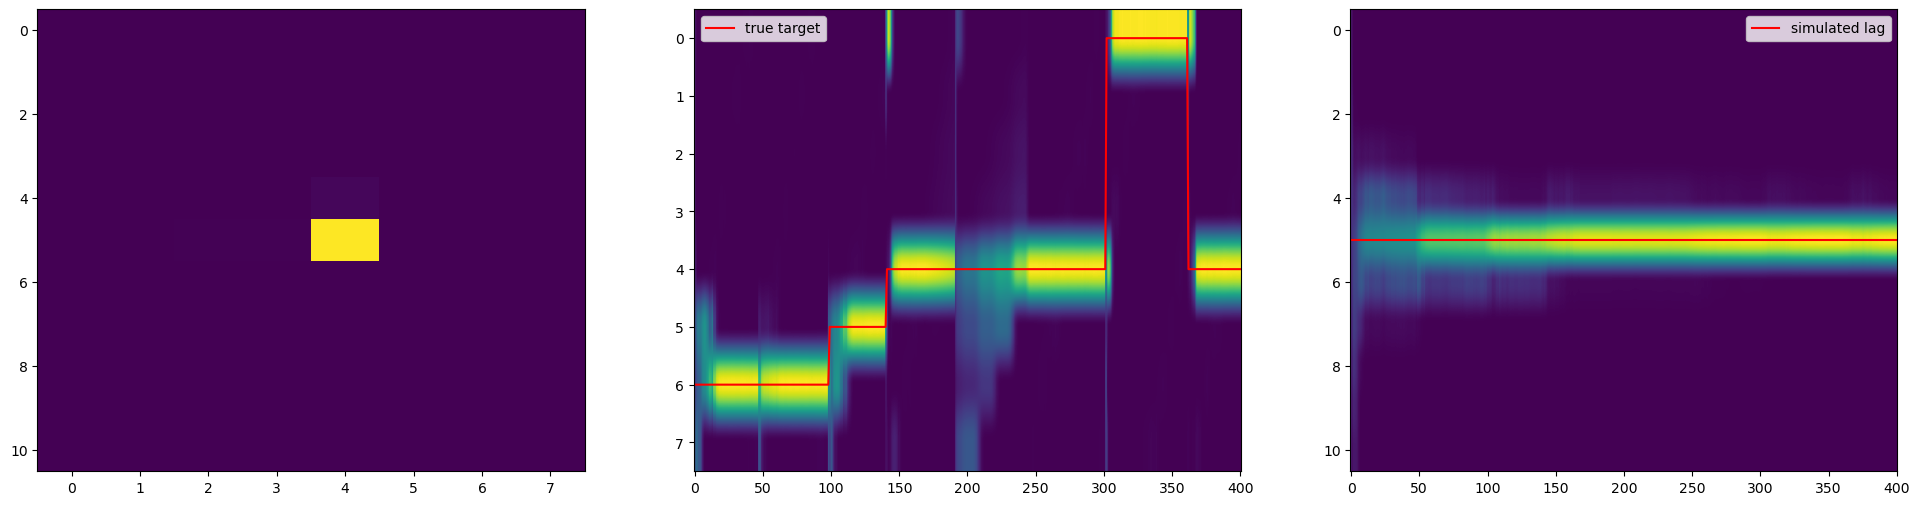

In [109]:
# plot belief
os_view = os

fig, axes = plt.subplots(1, 3, figsize=(3*8, 6))

# joint instantaneous belief
plt.sca(axes[0])
plt.imshow(loop.observer.q, aspect='auto')

# belief about targets over time
plt.sca(axes[1])
qs = [o['belief']['target'] for o in os_view]
plt.imshow(np.array(qs).T, aspect='auto')
plt.plot([o['user_target']['s'] for o in os_view], 'r', label='true target')
plt.legend()

# belief about conductivity over time
plt.sca(axes[2])
qs = [o['belief']['conductivity'] for o in os_view]
plt.imshow(np.array(qs).T, aspect='auto')
plt.plot([0, len(qs)-1], [user_state['conductivity_index']]*2, 'r', label='simulated lag')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


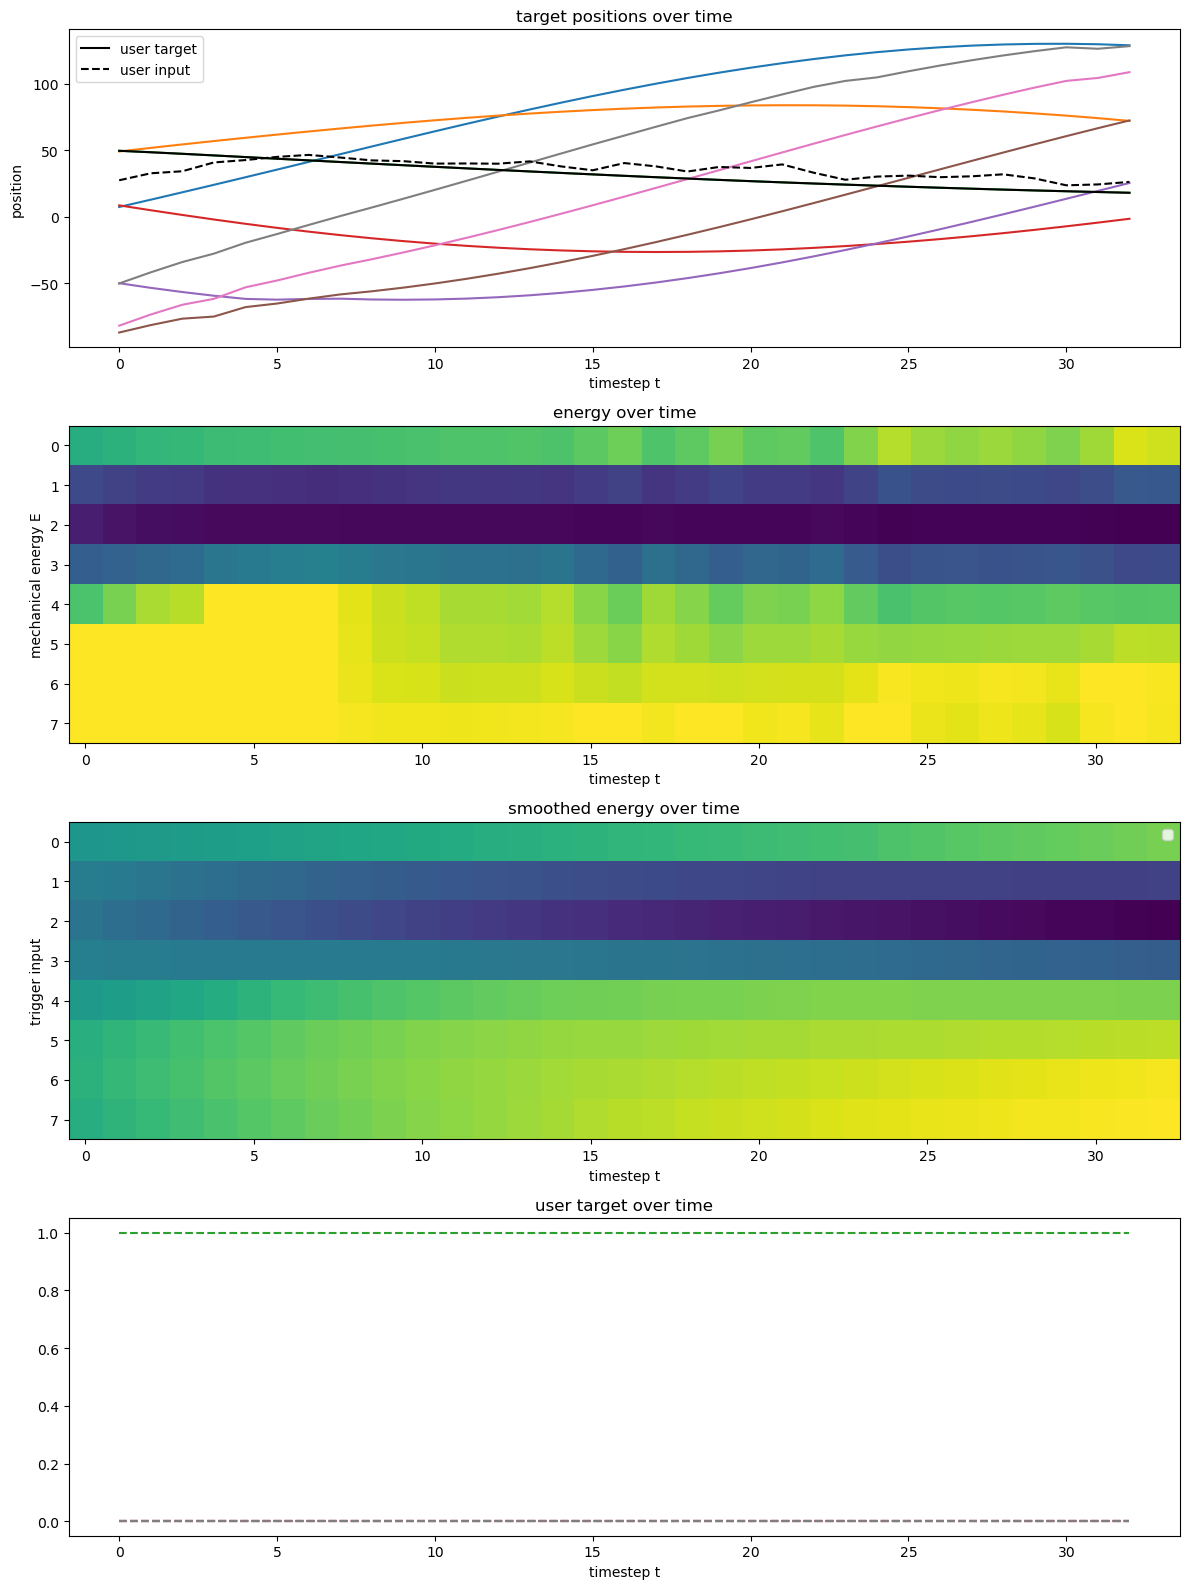

In [158]:
# plot dynamics
os = os

def plot_positions(os, ax):
  # target positions over time
  plt.sca(ax)
  plt.title('target positions over time')
  xs = np.array([o['ui']['x'] for o in os])
  ts = np.array([o['user_target']['s'] for o in os])
  plt.plot(xs)
  plt.plot(xs[np.arange(ts.shape[0]),ts], 'k-', label='user target')
  plt.xlabel('timestep t')
  plt.ylabel('position')  
  # user input over time
  y = np.array([o['user']['x'] for o in os])
  plt.plot(y, 'k--', label='user input')
  plt.legend()

def plot_velicities(os, ax):
  # target velocity over time
  plt.sca(ax)
  plt.title('target velocities over time')
  vs = np.array([o['ui']['v'] for o in os])
  plt.plot(vs)
  plt.xlabel('timestep t')
  plt.ylabel('velocity')

def plot_mass(os, ax):
  # target mass over time
  plt.sca(ax)
  plt.title('mass over time')
  ms = np.array([o['ui']['debug']['mass'] for o in os])
  plt.plot(ms)
  plt.plot(ms[np.arange(num_steps+1),ts], 'k-', label='user target')
  plt.xlabel('timestep  t')
  plt.ylabel('mass')

def plot_spring(os, ax):
  # target spring coefficient
  plt.sca(ax)
  plt.title('spring coefficient over time')
  ss = np.array([o['ui']['debug']['spring'] for o in os])
  plt.plot(ss)
  plt.plot(ss[np.arange(num_steps+1),ts], 'k-', label='user target')
  plt.xlabel('timestep t')
  plt.ylabel('spring coefficient')

def plot_energies(os, ax):
  # target energies
  plt.sca(ax)
  plt.title('energy over time')
  es = np.array([o['ui']['debug']['energy'] for o in os])
  #plt.semilogy(es)
  plt.imshow(es.T, aspect='auto')
  plt.xlabel('timestep t')
  plt.ylabel('mechanical energy E')
  
def plot_trigger_input(os, ax):  
  # trigger input over time
  y = np.array([o['trigger_in'] for o in os])
  plt.sca(ax)
  #plt.plot(y)
  #plt.plot([0, len(os)], [threshold]*2, 'k--', label='threshold')
  plt.imshow(y.T, aspect='auto')
  plt.legend()
  plt.xlabel('timestep t')
  plt.ylabel('trigger input')
  plt.title('smoothed energy over time')
  
def plot_trigger_output(os, ax):
  # trigger output over time
  y = np.array([o['trigger_out'] for o in os])
  plt.sca(axes[7])
  plt.plot(y)
  plt.xlabel('timestep t')
  plt.ylabel('trigger output')
  plt.title('events triggered over time')
  
def plot_user_target(os, ax):
  # user target
  plt.sca(ax)
  plt.title('user target over time')
  ts = np.array([o['user_target']['s_one_hot'] for o in os])
  plt.plot(ts, '--')
  plt.xlabel('timestep t')
  
def plot_belief(os, ax, varname='target'):
  # plot belief
  plt.sca(ax)
  plt.title('Observer belief over time')
  qs = [o['belief'][varname] for o in os]
  plt.imshow(np.array(qs).T, aspect='auto')
  plt.plot([o['user_target']['s'] for o in os], 'r')
  plt.xlabel('timestep t')
  plt.ylabel('target id')
  
def plot_max_belief(os, ax, varname='target'):
  plt.sca(ax)
  plt.title('Observer max. belief over time')
  qs = np.array([o['belief'][varname] for o in os])
  plt.plot(qs.max(axis=1))

num_plots = 4
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 4*num_plots))

plot_positions(os, axes[0])
#plot_velocities(os, axes[1])
#plot_mass(os, axes[2])
#plot_spring(os, axes[3])
plot_energies(os, axes[1])
plot_trigger_input(os, axes[2])
plot_user_target(os, axes[3])
#plot_trigger_output(os, axes[7])
#plot_belief(os, axes[2])
#plot_max_belief(os, axes[2])

plt.tight_layout()

(17, 8)


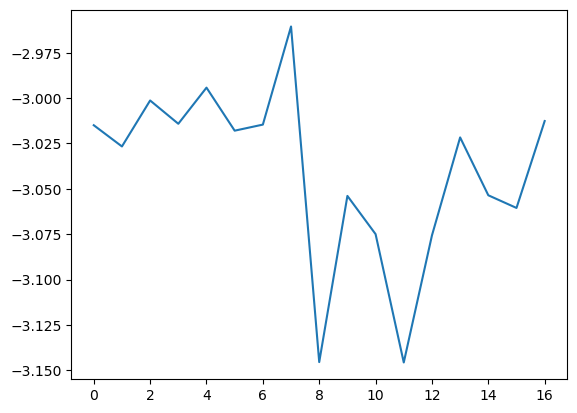

In [154]:
# loop model
class LoopModel:
  """ Rollout of User-UI interaction in response to active inference agent actions. """
  
  def __init__(self, loop, prev_obs, user_state):
    self.loop = loop
    self.s = prev_obs
    self.user_state = user_state
    
    self.ui = loop.ui.copy()
    self.trigger_in = loop.trigger_in.copy()
    self.trigger_out_fn = loop.trigger_out
    self.user_target = loop.user_target.copy()
    self.user_target.assign(self.user_state['target']) # init user target
    self.user_model = loop.observer.model
    self.observer = loop.observer.copy()
    
    self.s = prev_obs
    
  def step(self, control_state=None):
    # implement the action
    if control_state is not None:
      #self.ui.set_frequency(self.ui.frequency() * control_state)
      self.ui.set_energy(self.ui.energy() * control_state)
    
    s = self.s
    # propagate model through time
    # - reset UI when event has been triggered
    if s['trigger_out'].sum() > 0:
      self.ui.reset()
      self.trigger_in.reset()
      
    o = {}
    o['ui'] = self.ui.step(s['user']['x'])
    o['trigger_in'] = self.trigger_in.step(o['ui']['debug']['energy'])['x']
    o['trigger_out'] = self.trigger_out_fn(o['trigger_in'])
    
    # resample user goal if their target has been triggered
    o['user_target'] = self.user_target.step(s['trigger_out'])
    o['user'] = s['user'] # pass last state to user for lag estimation
    o['user'] = self.user_model.sample_action(o, self.user_state['conductivity'])

    # update belief over user hidden state
    o['belief'] = self.observer.step(o)
    
    self.s = o
    return self.s
    
# simulate some burn in
#os = [loop.reset()] + [loop.step() for _ in range(5)]
    
# construct action evaluation

# setup
num_targets = 8
time_horizon = 100 # maximum time to consider
delta_frequency = 0.2 # increase or decrease by x percent per step
num_rollouts = 32
# multiplicative control states
num_actions = 2*num_targets+1
us = np.ones((num_actions, num_targets))
us = us + np.vstack([
        np.eye(num_targets) * delta_frequency, # increase by 10%
        np.eye(num_targets) * -delta_frequency, # decrease by 10&
        np.zeros((1,num_targets))]) # leave unchainged

print(us.shape)
# define pragmatic value
p_c = [0.05-1e-4, # triggered nothing
       0.95, # triggered target
       1e-4] # triggered the wrong
log_p_c = np.log(p_c)

# generate a set of plans repeating the same action over the time horizon
plans = (np.arange(num_actions)[:,None] * np.ones((num_actions, time_horizon))).astype(int)

# generate a set of plans, each doing nothing after the first timestep
#first_action = np.arange(num_actions)[:,None]
#remaining_actions = np.ones((num_actions, time_horizon-1)) * (num_actions - 1)
#plans = np.hstack( [first_action, remaining_actions] ).astype(int)

# - test concept with plan of always taking no action
nefes = []
for plan in plans:
  #print(plan)
  total_steps = 0
  pragmatic = 0
  
  for _ in range(num_rollouts):
    # - sample user state from belief distribution
    user_state = loop.observer.sample()
    # - rollout policy over fixed time horizon or crop if trigger occured
    loop_model = LoopModel(loop=loop, prev_obs=os[-1], user_state=user_state)
    q_ss = []
    for a in plan:
      q_ss.append(loop_model.step(us[a]))
      if q_ss[-1]['trigger_out'].sum() > 0:
        break
    
    pragmatic += (len(q_ss)-1) * log_p_c[0] # all but one timestep was not triggered
    if q_ss[-1]['trigger_out'].sum() < 0.5:
      pragmatic += log_p_c[0]
    elif q_ss[-1]['trigger_out'][user_state['target']]:
      pragmatic += log_p_c[1]
    else:
      pragmatic += log_p_c[2]
      
    total_steps += len(q_ss)
        
  nefes.append(pragmatic/ total_steps)
  
plt.plot(nefes)

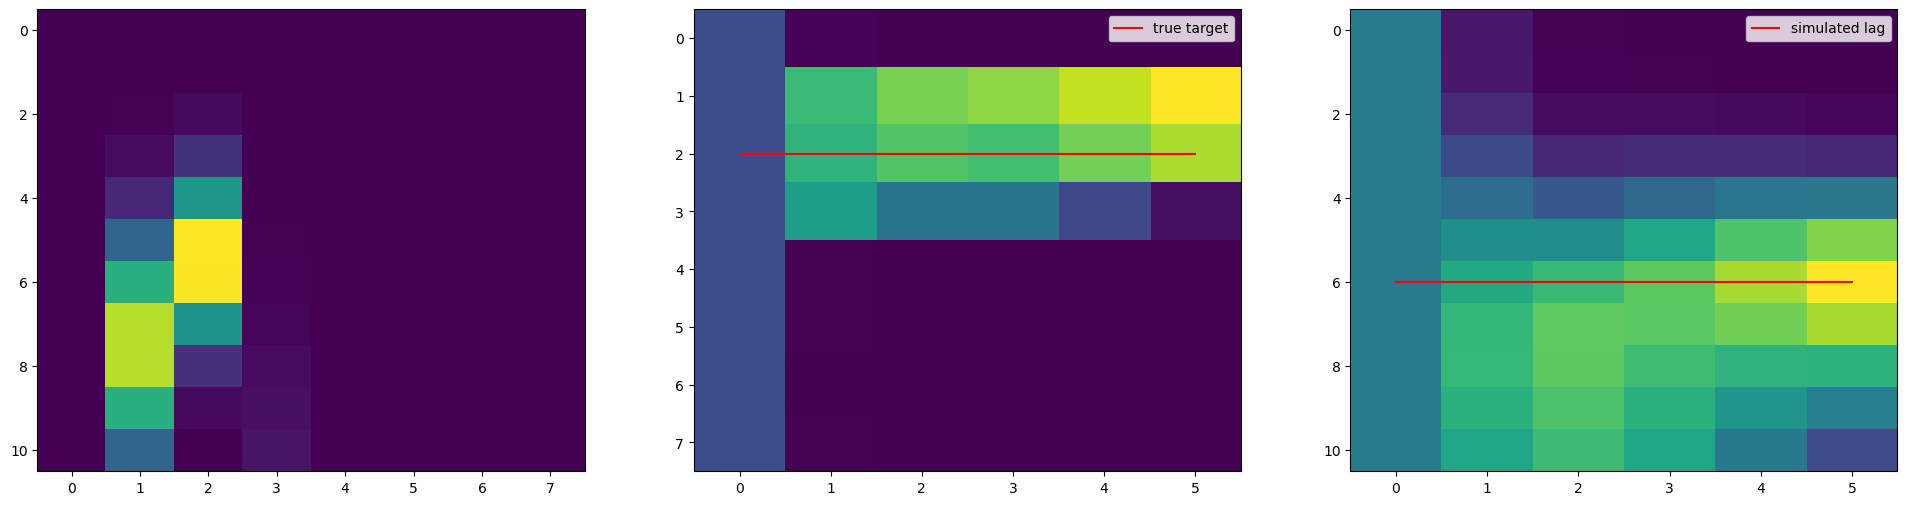

In [145]:
# plot belief
os_view = os

fig, axes = plt.subplots(1, 3, figsize=(3*8, 6))

# joint instantaneous belief
plt.sca(axes[0])
plt.imshow(loop.observer.q, aspect='auto')

# belief about targets over time
plt.sca(axes[1])
qs = [o['belief']['target'] for o in os_view]
plt.imshow(np.array(qs).T, aspect='auto')
plt.plot([o['user_target']['s'] for o in os_view], 'r', label='true target')
plt.legend()

# belief about conductivity over time
plt.sca(axes[2])
qs = [o['belief']['conductivity'] for o in os_view]
plt.imshow(np.array(qs).T, aspect='auto')
plt.plot([0, len(qs)-1], [user_state['conductivity_index']]*2, 'r', label='simulated lag')
plt.legend()

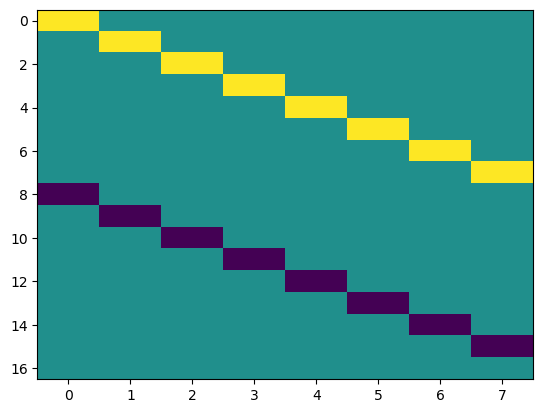

In [71]:
# multiplicative control states
num_actions = 2*num_targets+1
us = np.ones((num_actions, num_targets))
us = us + np.vstack([
        np.eye(num_targets) * 0.1, # increase by 10%
        np.eye(num_targets) * -0.1, # decrease by 10&
        np.zeros((1,num_targets))]) # leave unchainged

plt.imshow(us, aspect='auto')

## Bayesian Inference of Intent

This section runs the Bayesian belief update of an active inference agent on an observed simulation of interaction and visualises the belief over targets.

For that we define a likelihood-based generative model of user input. Here, we use a model that is similar to the generative process with some small differences and one free parameter that needs to be inferred from observations of interaction. The user model perceives the oscillator positions exactly, acts to track with some delay represented as a first-order lag with parameter $\lambda_{model}$ and with motor imprecision represented as Gaussian white noise on the lagging positions.

$x_{model} = \text{lag}(x_{gui}^{t}, x_{usr}^{t-1};\lambda_{model})+ \mathcal{N}(0;\sigma_{model}^2) \approx x_{usr} = \text{lag}( \mathcal{N}(x_{gui};\sigma_{usr}^2), x_{usr}^{t-1}; \lambda_{usr} )$

While we keep the model very close to the simulated user apart from it not having access to the intended target, 
itt does not match exactly and the lag parameter $\lambda_{model}$ is unknown a priori.

## Acting to increase pragmatic value

We show how action can help to gain information about user intent and to increase the probability of observing preferred state by intervening on the mediating mechanism instead of the decision rule itself. This is in contrast to previous work such as BIGNav, which used Bayesin information gain directly for control by triggering events compatible with current belief directly. We argue that the proposed approach is more generalisable as it requires only access to the communication layer as opposed to the controlled software. It can also enable adapting faster to parameters of the user that are consistent across applications, such as touch offsets, by learning from their interaction with multiple applications.

In active inference, sequences of actions (plans) are scored by the negative expected free energy, and selected by exponentiating and normalizing, i.e. sampling from the softmax over plans. Plans $\pi: a_0, a_1, ..., a_{K-1}$ define sequences of actions up to a finite horizon of $K$ timesteps into the future. The expected free energy can be decomposed in various ways and here we chose one that we find most intuitive, involving a _pragmatic_ term and an _information gain_ term. 

The _pragmatic_ term assesses the probability of arriving in states following $\pi$ that the agent desires, or of encountering observations that the agent desires. In this context, $Q_\theta$ is estimated by propagating beliefs through the environment transition dynamics following the sequence of actions defined by $\pi$, and observations are halucinated by sampling from the emission probability distributions.

$\mathbb{E}_{s \sim Q_{\theta}}\left[\log p_c(s)\right] \quad \text{or} \quad \mathbb{E}_{s \sim Q_{\theta}, o \sim p(o|s)}\left[\log p_c(o)\right]$

The _information gain_ term quantifies the belief update due to making observations in future states.

$\mathbb{E}_{s \sim Q_{\theta}, o \sim p(o|s)}\left[ D_{KL}(\, Q_{\theta'}(s|o),  Q_{\theta}(s) \,) \right]$


We consider actions to represent interventions on individual masses of the oscillating mechanism associated with different targets. An increase in mass increases kinetic energy and decreases the oscillation frequency, whereas a decrease in mass decreases kinetic energy and increases the oscillation frequency, respectively. A discrete action space is defined over $2N+1$ actions corresponding to no intervention, increasing, or decreasing the mass of $N$ individual targets by a fixed proportion ($\pm10\%$).

The preferences over states and observations of an adaptive user interface could be informed by a variety of factors including the users' intent, e.g., preferring observations that are compatible with the application behaving as the user intends), the risk associated with different application states, e.g., preferring observations that are incompatible with the application being driven into unsafe states, and a policy to nudge users into preferable application states, e.g., to expose users to new features or to increase their chance of picking more healthy, more economical, or more environmentally friendly options. Because most of these factors assume some domain knowledge of the application to be meaningful, we focus here on the first, i.e. preferring observations that are compatible with user intention.

### Option A: preference over trigger events

Here, we define the preference distribution over observations as a function of our belief about the user's intended target and observed trigger events. Action selection thereby attempts to drive the dynamic system into a configuration that makes it easier for the user to decrease their intended target's energy, harder for the user to accidentally decrease any other target's energy, and potentially assists with energy reduction directly.

One drawback of this approach is that hypothetical trigger events are sparse and we therefore need long rollouts to identify an effect

### Option B: preference over energy vectors

## Acting to increase information gain

In order to resolve ambiguity in user intention to trigger different targets (maximising information gain) it would be useful to desynchronise those targets' movement. 

In [ ]:
# sketch action mechanism

# generate set of 2*N+1 discrete actions
# control states
us = np.vstack([
        np.eye(num_targets) * 4, # target_value / mass_0 - 1
        np.eye(num_targets) * -0.8, 
        np.zeros((1,num_targets))])

# apply control state associated with selected action
a = 1
mass_pre = np.ones(num_targets)
mass_post = mass_pre * (1 + us[a])
plt.plot(mass_pre)
plt.plot(mass_post)
plt.plot(us[a])

# evaluate the pragmatic value
# - propagate 

In [ ]:
# complete action selection with pragmatic value

# 1. do a rollout of the future with sampled initial target state and sampled user model parameter
o = os[-1]
rollout_target = rng.choice(num_targets, p=o['belief']['target'])
rollout_conductivity = rng.choice(loop.observer.model.k, p=o['belief']['conductivity'])
print(rollout_target, rollout_conductivity)

## Selection Trigger (Active Inference)

In the simplest setting, we can perform belief updates using the model of the user and of the UI dynamics to reason about the user's target object.

In a more advanced setting, we can intervene on the UI to help resolve ambiguity by changing some of the objects' parameters (mass, spring constant, and damping constant).

In [ ]:
import importlib
import harmonic_interaction_01 as hi
importlib.reload(hi)

In [ ]:
num_steps = 1000 * 2

agents = hi.init()
os = [hi.reset(agents)]
for _ in range(num_steps):
  os.append(hi.step(agents, os[-1]))

In [ ]:
# plot dynamics
fig, axes = plt.subplots(8, 1, figsize=(12, 4*8))

# target positions over time
plt.sca(axes[0])
plt.title('target positions over time')
xs = np.array([o['ui']['x'] for o in os])
ts = np.array([o['user_target']['s'] for o in os])
plt.plot(xs)
plt.plot(xs[np.arange(num_steps+1),ts], 'k-', label='user target')
plt.xlabel('timestep t')
plt.ylabel('position')

# user input over time
y = np.array([o['sim_user'] for o in os])
plt.plot(y, 'k--', label='user input')
plt.legend()

# target velocity over time
plt.sca(axes[1])
plt.title('target velocities over time')
vs = np.array([o['ui']['v'] for o in os])
plt.plot(vs)
plt.xlabel('timestep t')
plt.ylabel('velocity')

# target mass
plt.sca(axes[2])
plt.title('mass over time')
ms = np.array([o['ui']['debug']['mass'] for o in os])
plt.plot(ms)
plt.plot(ms[np.arange(num_steps+1),ts], 'k-', label='user target')
plt.xlabel('timestep  t')
plt.ylabel('mass')

# target spring coefficient
plt.sca(axes[3])
plt.title('spring coefficient over time')
ss = np.array([o['ui']['debug']['spring'] for o in os])
plt.plot(ss)
plt.plot(ss[np.arange(num_steps+1),ts], 'k-', label='user target')
plt.xlabel('timestep t')
plt.ylabel('spring coefficient')

# target energies
plt.sca(axes[4])
plt.title('energy over time')
es = np.array([o['ui']['debug']['energy'] for o in os])
plt.plot(es)
plt.xlabel('timestep t')
plt.ylabel('mechanical energy E')

# user target
plt.sca(axes[5])
plt.title('user target over time')
ts = np.array([o['user_target']['s_one_hot'] for o in os])
plt.plot(ts, '--')
plt.xlabel('timestep t')

# trigger output over time
y = np.array([o['trigger_out'] for o in os])
plt.sca(axes[6])
plt.plot(y)
plt.xlabel('timestep t')
plt.ylabel('trigger output')
plt.title('events triggered over time')

# trigger input over time
y = np.array([o['trigger_in'] for o in os])
plt.sca(axes[7])
plt.plot(y)
plt.plot([0, len(os)], [threshold]*2, 'k--', label='threshold')
plt.legend()
plt.xlabel('timestep t')
plt.ylabel('trigger input')
plt.title('smoothed energy over time')


plt.tight_layout()

In [ ]:
user = Register(s0=0, bounds=[0.2, 0.8])
display(user.reset())
display(user.step())
display(user.step(2.))
display(user.step())


# Legacy code

In [ ]:
# 8. reason about user intent by observing interaction

# a. traditional approach: moving average velocity below threshold, with
# initial value, capcity (moving average weight) and threshold finetuned
# tie-break on value if threshold is crossed by multiple targets
# - fine-tune initial value to maximum peak velocity
# - fine-tune conductivity to reduce oscillation in controlled object's score
#   near convergence
# - fine-tune threshold to separate controlled from uncontrolled objects
# - trigger action if a single object's score is below threshold

num_objects = 16
num_steps = 200
fig, ax = plt.subplots(figsize=(8*2, 12))

mass = np.ones(num_objects) + np.linspace(0, 1, num_objects)
ui = MassSpringDamper(mass=mass, bounds=[-1, 1])
user = FirstOrderLag(conductivity=0.1)

reasoner = FirstOrderLag(conductivity=0.05, s0=0.1)
#reasoner = SimpleMovingAverage(buffer_size=64, s0=np.ones(num_objects)*0.02)
threshold = 0.001

os_ui = []
os_user = []
ss_reasoner = []
os_reasoner = []

user.reset()
reasoner.reset()
o_ui = ui.reset()

for _ in range(num_steps):
  # stimulus response - target system at index 0
  o_user = user.step(o_ui['x'][-1])
  # log stimulus and response
  os_ui.append(o_ui['x'])
  os_user.append(o_user)
  # simulate next stimulus
  o_ui = ui.step(o_user)
  # reason about ui response to user input
  s_reasoner = reasoner.step(np.abs(o_ui['dx']))
  o_reasoner = s_reasoner < threshold
  ss_reasoner.append(s_reasoner)
  os_reasoner.append(o_reasoner)
  """
  if np.sum(o_reasoner > 1e-6):
    # object selected
    break
  """
  
plt.plot(ss_reasoner, '-');
plt.plot(np.max(np.array(os_reasoner), axis=1) * np.max(ss_reasoner), 'k-', label='triggered');
plt.plot([0, num_steps], [threshold, threshold], 'k--', label='threshold');
plt.xlabel('timestep t')
plt.ylabel('selection score (lower is better)')
plt.legend()